## Imports

In [58]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, SimpleRNN
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import random

import pickle

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, accuracy_score
from sklearn.metrics import average_precision_score, roc_auc_score

from sklearn.metrics import multilabel_confusion_matrix

%matplotlib inline

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

[]


2022-12-30 21:36:19.939803: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-12-30 21:36:19.939852: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Lucky
2022-12-30 21:36:19.939873: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Lucky
2022-12-30 21:36:19.940007: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.60.11
2022-12-30 21:36:19.940024: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.60.11
2022-12-30 21:36:19.940029: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.60.11


In [62]:
with open('./data/xl.pickle', 'rb') as xl_file:
    xl = (pickle.load(xl_file))

with open('./data/yl.pickle', 'rb') as yl_file:
    yl = pickle.load(yl_file)


SAVE = False
LOAD = True


# Predictive Model

## Understanding the data
There are 50000 records. Each record is a sequence of outputs from 3 sensors.
Each record is multi-labeled, there are 5 types of defects and they are nonexclusive.






In [4]:
df = pd.DataFrame(
    {
        'sequence': xl,
        'defects' : yl
    }
)
df['seq_len'] = df.sequence.map(len)

In [5]:

print(f'minimal length of a sequence: {min(df.seq_len)}')
print(f'maximal length of a sequence: {max(df.seq_len)}')

minimal length of a sequence: 40
maximal length of a sequence: 59


<AxesSubplot: >

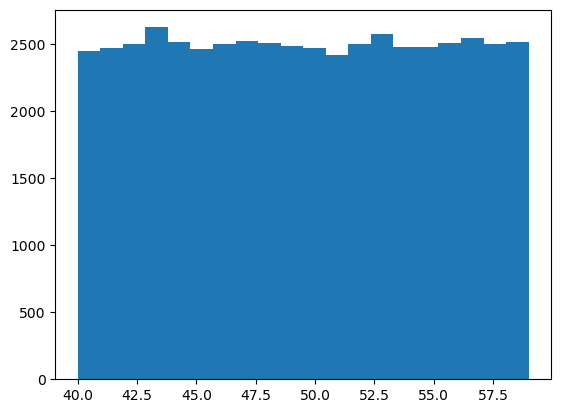

In [6]:
df.seq_len.hist(grid=False, bins=20)

### Issues with the data

#### 1. Training examples vary in length
We can solve this issue with the following approaches:
1. Truncate each training example (then each example has the same lenght and we can easily train our models)
Drawbacks:
- information loss
- labeling errors (if a defect is present in a part of the sequence that has been truncated, then we introduce noise to the data)

2. Write custom data generator that will feed the network with training batches having the same number of samples in each example. (Within a single batch, each training example has to have equal shape, but between batches shapes may vary)



## Data Split
We will use the same splits for all the models, to be able to compare them

In [7]:
df_train = df.iloc[:40000]
df_val = df.iloc[40000:45000]
df_test = df.iloc[45000:]

# defining test array
y_test = np.stack(df_test.defects, axis=0).astype(int)

## Building the models

### 1st approach - truncating the training data


In [8]:



df_train_trunc = df_train.copy()
df_train_trunc.sequence = [sample[:40] for sample in df_train_trunc.sequence]

df_val_trunc = df_val.copy()
df_val_trunc.sequence = [sample[:40] for sample in df_val_trunc.sequence]

df_test_trunc = df_test.copy()
df_test_trunc.sequence = [sample[:40] for sample in df_test_trunc.sequence]


X_train_trunc = np.stack(df_train_trunc.sequence, axis=0)
y_train_trunc = np.stack(df_train_trunc.defects, axis=0)

X_val_trunc = np.stack(df_val_trunc.sequence, axis=0)
y_val_trunc = np.stack(df_val_trunc.defects, axis=0)

X_test_trunc = np.stack(df_test_trunc.sequence, axis=0)
y_test_trunc = np.stack(df_test_trunc.defects, axis=0)

Building the model

In [9]:
model = Sequential()
model.add(LSTM(64, input_shape=(None, 3))) # return_seq = False now
model.add(Dense(5, 'sigmoid'))
model.compile(loss='binary_crossentropy', metrics='acc', optimizer='adam')


2022-12-30 21:36:52.325334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training

In [10]:
early = EarlyStopping(patience=10)

model.fit(X_train_trunc, y_train_trunc, validation_data=(X_val_trunc, y_val_trunc), batch_size=64, epochs=50, callbacks=[early])

Epoch 1/50
625/625 [==============================] - 12s 18ms/step - loss: 0.3835 - acc: 0.3768 - val_loss: 0.3109 - val_acc: 0.4388
Epoch 2/50
625/625 [==============================] - 10s 16ms/step - loss: 0.2921 - acc: 0.4562 - val_loss: 0.2622 - val_acc: 0.4556
Epoch 3/50
625/625 [==============================] - 10s 16ms/step - loss: 0.2538 - acc: 0.4951 - val_loss: 0.2296 - val_acc: 0.5332
Epoch 4/50
625/625 [==============================] - 11s 17ms/step - loss: 0.2349 - acc: 0.5034 - val_loss: 0.2173 - val_acc: 0.5660
Epoch 5/50
625/625 [==============================] - 11s 18ms/step - loss: 0.2214 - acc: 0.5138 - val_loss: 0.2003 - val_acc: 0.5328
Epoch 6/50
625/625 [==============================] - 11s 18ms/step - loss: 0.2072 - acc: 0.5242 - val_loss: 0.1923 - val_acc: 0.5302
Epoch 7/50
625/625 [==============================] - 11s 18ms/step - loss: 0.1941 - acc: 0.5290 - val_loss: 0.1802 - val_acc: 0.5344
Epoch 8/50
625/625 [==============================] - 11s 18ms

In [13]:
if SAVE:
    model.save('./models/model1')

if LOAD:
    model = load_model('./models/model1')

INFO:tensorflow:Assets written to: ./models/model1/assets


INFO:tensorflow:Assets written to: ./models/model1/assets


Evaluation

In [15]:
class TestDataGenerator(Sequence):
    """Data generator that passes samples one by one, without shuffling"""
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(inplace=False, drop=True)

    def on_epoch_end(self):
        '''This function is called at the end of each epoch'''
        pass

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.df.shape[0]
    
    def __getitem__(self, index):
        return np.expand_dims(self.df.iloc[index, 0], axis=0), self.df.iloc[index, 1]

In [17]:
testGenerator = TestDataGenerator(df_test)

In [18]:
y_pred = model.predict(testGenerator).round().astype(int)
model.evaluate(testGenerator)

5000/5000 [==============================] - 18s 3ms/step - loss: 0.1096 - acc: 0.6990


[0.10963983088731766, 0.6990000009536743]

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

cf = multilabel_confusion_matrix(y_test, y_pred, samplewise=False)
cf


array([[[3736,    0],
        [  10, 1254]],

       [[3738,   27],
        [   6, 1229]],

       [[3310,  452],
        [  19, 1219]],

       [[3741,    0],
        [  10, 1249]],

       [[3724,    0],
        [   0, 1276]]])

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test.astype(int), y_pred, target_names=['def1','def2','def3','def4','def5'], zero_division=0))

              precision    recall  f1-score   support

        def1       1.00      0.99      1.00      1264
        def2       0.98      1.00      0.99      1235
        def3       0.73      0.98      0.84      1238
        def4       1.00      0.99      1.00      1259
        def5       1.00      1.00      1.00      1276

   micro avg       0.93      0.99      0.96      6272
   macro avg       0.94      0.99      0.96      6272
weighted avg       0.94      0.99      0.96      6272
 samples avg       0.74      0.77      0.75      6272



Remarks

#TODO : add remarks

### 2nd approach - feed the NN with batches containing sequences of the same length


In [21]:
class DataGenerator(Sequence):
    def __init__(self, df, batchSize=64, shuffle=True, sequenceToTake=0):
    
        self.sequenceToTake = sequenceToTake
        self.batchSize = batchSize
        self.shuffle = shuffle
        self.df = df
        self.indicies_dict = df.groupby('seq_len').indices
        self.batches = []
        self.generate_batches()

    def on_epoch_end(self):
        '''This function is called at the end of each epoch'''
        self.batches = []
        self.generate_batches()
            
    def generate_batches(self):
        """At the end of each epoch, generate new batches of indices"""
        for key, value in self.indicies_dict.items():
            if self.shuffle:
                random.shuffle(value)
            splitted = np.array_split(value, len(value)//self.batchSize) # FIXME
            self.batches += splitted[:-1]

        if self.shuffle:
            random.shuffle(self.batches)

    def __getitem__(self, index):
        """
        Returns one batch.
        One batch contains the set of sequences of the same length
        """


        x = np.stack(self.df.iloc[self.batches[index], self.sequenceToTake], axis=0)
        y = np.stack(self.df.iloc[self.batches[index], 1], axis=0)

        return x, y

    def __len__(self):
        'Denotes the number of batches per epoch'

        return len(self.batches)

In [22]:
trainGenerator = DataGenerator(df_train)
valGenerator = DataGenerator(df_val, batchSize=16)


In [23]:
model2 = Sequential()
model2.add(LSTM(64, input_shape=(None, 3))) # return_seq = False now
model2.add(Dense(5, 'sigmoid'))
model2.compile(loss='binary_crossentropy', metrics='acc', optimizer='adam')

In [24]:
early = EarlyStopping(patience=10)

model2.fit(trainGenerator, validation_data= valGenerator, epochs=50, callbacks=[early])

Epoch 1/50
595/595 [==============================] - 18s 28ms/step - loss: 0.3770 - acc: 0.3486 - val_loss: 0.2860 - val_acc: 0.4050
Epoch 2/50
595/595 [==============================] - 15s 26ms/step - loss: 0.2686 - acc: 0.4323 - val_loss: 0.2835 - val_acc: 0.3815
Epoch 3/50
595/595 [==============================] - 18s 30ms/step - loss: 0.2394 - acc: 0.4430 - val_loss: 0.2115 - val_acc: 0.4388
Epoch 4/50
595/595 [==============================] - 17s 28ms/step - loss: 0.2244 - acc: 0.4471 - val_loss: 0.3341 - val_acc: 0.3140
Epoch 5/50
595/595 [==============================] - 16s 27ms/step - loss: 0.2018 - acc: 0.4527 - val_loss: 0.2348 - val_acc: 0.4492
Epoch 6/50
595/595 [==============================] - 17s 28ms/step - loss: 0.1852 - acc: 0.4617 - val_loss: 0.1665 - val_acc: 0.4678
Epoch 7/50
595/595 [==============================] - 15s 26ms/step - loss: 0.1718 - acc: 0.4658 - val_loss: 0.1421 - val_acc: 0.4742
Epoch 8/50
595/595 [==============================] - 16s 27ms

In [29]:
if SAVE:
    model2.save('./models/model2')

if LOAD:
    model2 = load_model('./models/model2')

INFO:tensorflow:Assets written to: ./models/model2/assets


INFO:tensorflow:Assets written to: ./models/model2/assets


In [30]:
y_pred = model2.predict(testGenerator).round().astype(int)
model2.evaluate(testGenerator)

5000/5000 [==============================] - 16s 3ms/step - loss: 0.0148 - acc: 0.4960


[0.014816924929618835, 0.4959999918937683]

In [31]:
cf = multilabel_confusion_matrix(y_test.astype(int), y_pred, samplewise=False)
cf

array([[[3736,    0],
        [  25, 1239]],

       [[3765,    0],
        [   6, 1229]],

       [[3750,   12],
        [  49, 1189]],

       [[3741,    0],
        [   1, 1258]],

       [[3724,    0],
        [   0, 1276]]])

In [32]:
print(classification_report(y_test.astype(int), y_pred, target_names=['def1','def2','def3','def4','def5'], zero_division=0))

              precision    recall  f1-score   support

        def1       1.00      0.98      0.99      1264
        def2       1.00      1.00      1.00      1235
        def3       0.99      0.96      0.97      1238
        def4       1.00      1.00      1.00      1259
        def5       1.00      1.00      1.00      1276

   micro avg       1.00      0.99      0.99      6272
   macro avg       1.00      0.99      0.99      6272
weighted avg       1.00      0.99      0.99      6272
 samples avg       0.77      0.76      0.76      6272



# Root cause analysis

Examining what patterns in the data are related to particular defects

1. statistical 
2. denoising ??



In [33]:
df.head()

,sequence,defects,seq_len
0,"[[0.266296985909937, 0.48574277170495817, 0.36...","[False, False, False, False, True]",58
1,"[[0.6106411704068081, 0.9499699673512058, 0.35...","[False, False, False, True, True]",51
2,"[[0.6214531835131287, 0.5707332403433221, 0.78...","[False, False, False, False, False]",59
3,"[[0.6094422267129465, 0.8629181724700395, 0.44...","[True, False, False, False, True]",41
4,"[[0.5072599887415982, 0.766663647815743, 0.325...","[False, True, False, False, False]",47


In [34]:
defects_split = pd.DataFrame(df.defects.to_list(), columns=[f'd{i}' for i in range(1,6)])
df = pd.concat([df, defects_split], axis=1).drop('defects', axis=1)
df.head()

,sequence,seq_len,d1,d2,d3,d4,d5
0,"[[0.266296985909937, 0.48574277170495817, 0.36...",58,False,False,False,False,True
1,"[[0.6106411704068081, 0.9499699673512058, 0.35...",51,False,False,False,True,True
2,"[[0.6214531835131287, 0.5707332403433221, 0.78...",59,False,False,False,False,False
3,"[[0.6094422267129465, 0.8629181724700395, 0.44...",41,True,False,False,False,True
4,"[[0.5072599887415982, 0.766663647815743, 0.325...",47,False,True,False,False,False


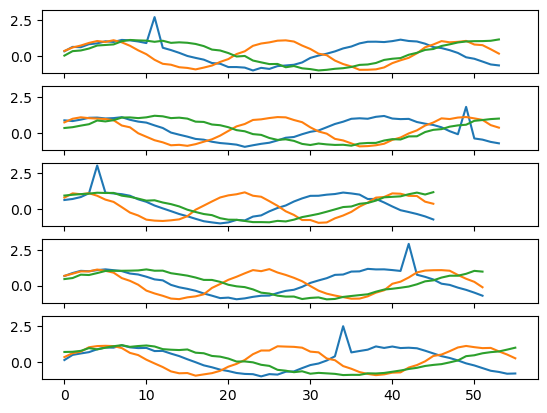

In [35]:
d1_only = df.loc[(df.d1) & (-df.d2) & (-df.d3) & (-df.d4) & (-df.d5)]

fig, ax = plt.subplots(5, sharey=True, sharex=True)

for i in range(5):
    ax[i].plot(d1_only.iloc[i,0])
    
plt.show()

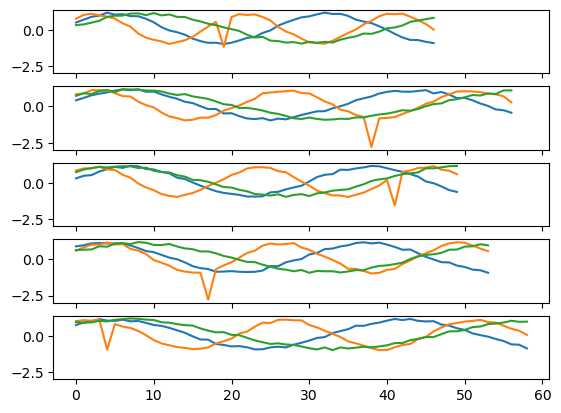

In [36]:
d2_only = df.loc[(-df.d1) & (df.d2) & (-df.d3) & (-df.d4) & (-df.d5)]

fig, ax = plt.subplots(5, sharey=True, sharex=True)

for i in range(5):
    ax[i].plot(d2_only.iloc[i,0])
    
plt.show()

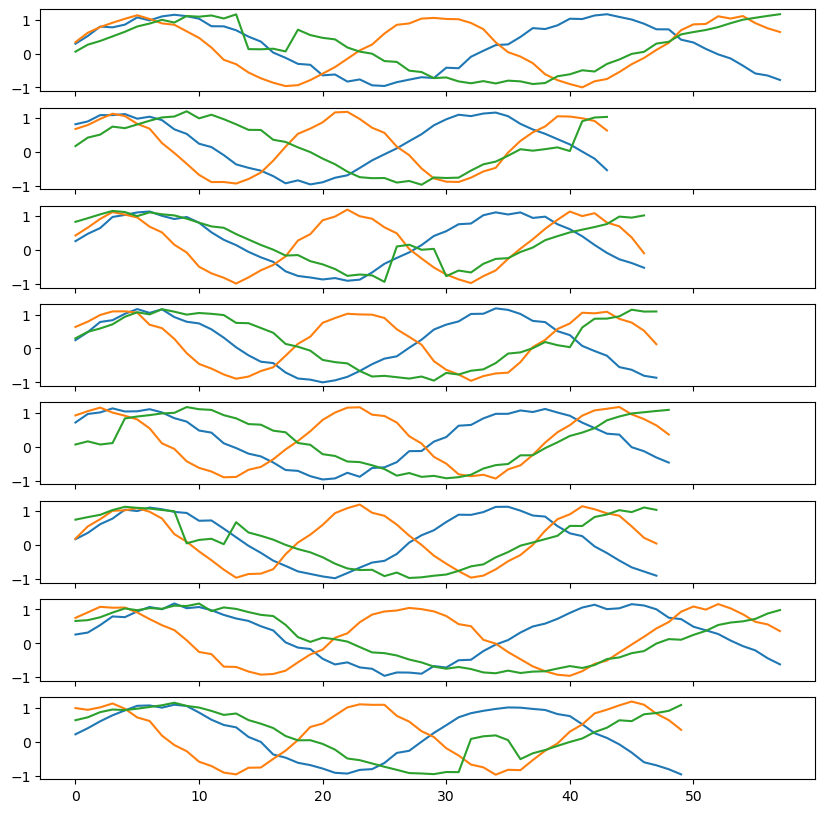

(3940, 7)

In [37]:
d3_only = df.loc[(-df.d1) & (-df.d2) & (df.d3) & (-df.d4) & (-df.d5)]

fig, ax = plt.subplots(8, sharey=True, sharex=True, figsize=(10,10))

for i in range(8):
    ax[i].plot(d3_only.iloc[i,0])
    
plt.show()
d3_only.shape

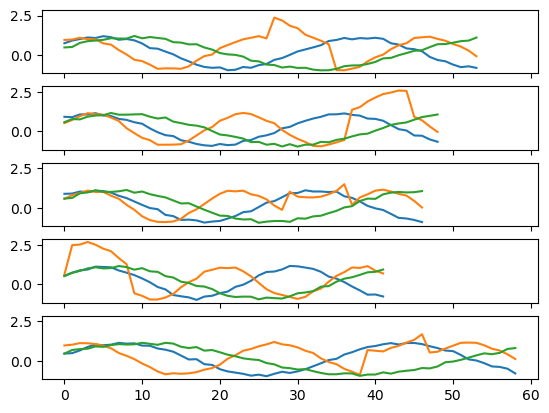

(4120, 7)

In [38]:
d4_only = df.loc[(-df.d1) & (-df.d2) & (-df.d3) & (df.d4) & (-df.d5)]

fig, ax = plt.subplots(5, sharey=True, sharex=True)

for i in range(5):
    ax[i].plot(d4_only.iloc[i,0])
    
plt.show()
d4_only.shape

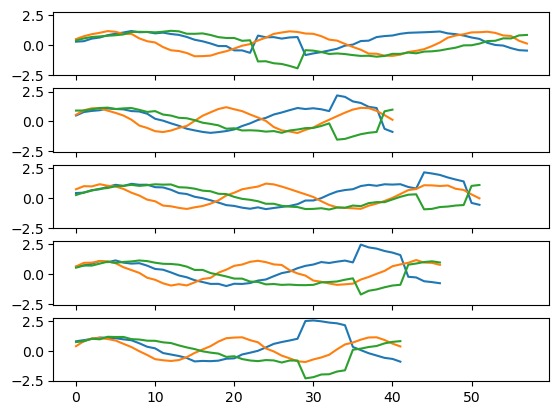

(3919, 7)

In [39]:
d5_only = df.loc[(-df.d1) & (-df.d2) & (-df.d3) & (-df.d4) & (df.d5)]

fig, ax = plt.subplots(5, sharey=True, sharex=True)

for i in range(5):
    ax[i].plot(d5_only.iloc[i,0])
    
plt.show()
d5_only.shape

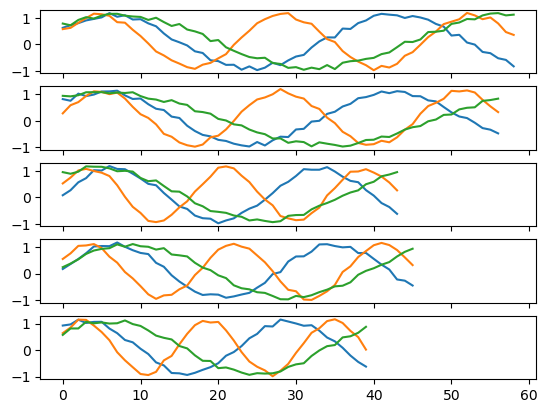

(11723, 7)

In [40]:
no_defect = df.loc[(-df.d1) & (-df.d2) & (-df.d3) & (-df.d4) & (-df.d5)]

fig, ax = plt.subplots(5, sharey=True, sharex=True)

for i in range(5):
    ax[i].plot(no_defect.iloc[i,0])

plt.show()
no_defect.shape

### Correlation between defects

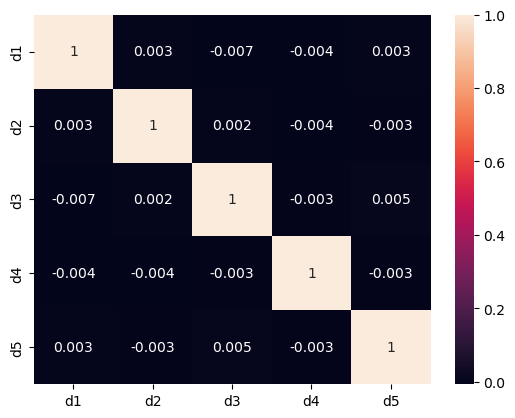

In [41]:
import seaborn as sns

ax = sns.heatmap(defects_split.corr().round(3),annot=True)

We see that all defects are independent, there is no correlation between the occurence ...

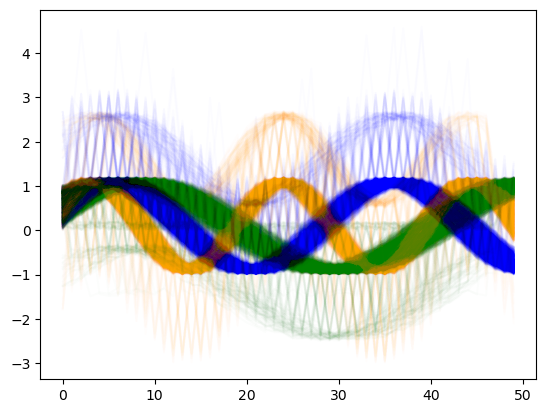

In [43]:

for sample in df.loc[df.seq_len==50].sequence:
    plt.plot(sample[:,0], color='b', alpha= 0.01)
    plt.plot(sample[:,1], color='orange', alpha= 0.01)
    plt.plot(sample[:,2], color='g', alpha= 0.01)

plt.show()

## Defect Localization

### Single Defect Localization

Testing defect detection for 1D sequence
Only to find defect1

In [44]:
df_trunc = df.copy()
df_trunc.sequence =  [sample[:40] for sample in df.sequence]

seq1 = [i[:,0] for i in df_trunc.sequence.to_list()]
seq2 = [i[:,1] for i in df_trunc.sequence.to_list()]
seq3 = [i[:,2] for i in df_trunc.sequence.to_list()]

df_trunc['seq1'] = seq1
df_trunc['seq2'] = seq2
df_trunc['seq3'] = seq3

df_detect_1 = df_trunc.loc[(-df.d2) & (-df.d3) & (-df.d4) & (-df.d5)]
X = np.stack(df_detect_1.seq1,axis=0)
display(X.shape)

y = np.stack(df_detect_1.d1, axis=0)
y.shape

X_train = X[:11000]
y_train = y[:11000]

X_val = X[11000:15000]
y_val = y[11000:15000]

X_test = X[15000:]
y_test = y[15000:]

(15714, 40)

In [45]:
inner_model = Sequential()
inner_model.add(LSTM(64, return_sequences=True, input_shape=(None,1)))
inner_model.add(LSTM(8, return_sequences=False))
inner_model.add(Dense(1, 'sigmoid'))

inner_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 64)          16896     
                                                                 
 lstm_3 (LSTM)               (None, 8)                 2336      
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 19,241
Trainable params: 19,241
Non-trainable params: 0
_________________________________________________________________


In [46]:
INTERVAL_LENGTH = 10


model = Sequential()
model.add(Reshape((-1, INTERVAL_LENGTH, 1), input_shape=(None,1)))
model.add(TimeDistributed(inner_model))
model.add(GlobalMaxPool1D()) # FIXME: 3D ?
model.compile(loss='binary_crossentropy', metrics='acc')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, None, 10, 1)       0         
                                                                 
 time_distributed (TimeDistr  (None, None, 1)          19241     
 ibuted)                                                         
                                                                 
 global_max_pooling1d (Globa  (None, 1)                0         
 lMaxPooling1D)                                                  
                                                                 
Total params: 19,241
Trainable params: 19,241
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.fit(X_train, y_train, batch_size = 128, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
86/86 [==============================] - 9s 60ms/step - loss: 0.5869 - acc: 0.7325 - val_loss: 0.5560 - val_acc: 0.7550
Epoch 2/20
86/86 [==============================] - 4s 43ms/step - loss: 0.5690 - acc: 0.7434 - val_loss: 0.5522 - val_acc: 0.7550
Epoch 3/20
86/86 [==============================] - 3s 37ms/step - loss: 0.5540 - acc: 0.7518 - val_loss: 0.5522 - val_acc: 0.7985
Epoch 4/20
86/86 [==============================] - 3s 39ms/step - loss: 0.5301 - acc: 0.7778 - val_loss: 0.5095 - val_acc: 0.7847
Epoch 5/20
86/86 [==============================] - 3s 40ms/step - loss: 0.5009 - acc: 0.7904 - val_loss: 0.4778 - val_acc: 0.8033
Epoch 6/20
86/86 [==============================] - 4s 42ms/step - loss: 0.4771 - acc: 0.8021 - val_loss: 0.4281 - val_acc: 0.8407
Epoch 7/20
86/86 [==============================] - 4s 47ms/step - loss: 0.4482 - acc: 0.8196 - val_loss: 0.4400 - val_acc: 0.8267
Epoch 8/20
86/86 [==============================] - 4s 41ms/step - loss: 0.4328 - a

In [48]:
if SAVE:
    model.save('./models/localization-model-single')

if LOAD:
    model = load_model('./models/localization-model-single')

INFO:tensorflow:Assets written to: ./models/localization-model-single/assets


INFO:tensorflow:Assets written to: ./models/localization-model-single/assets


In [49]:
model_slice = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
model_slice.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_input (InputLayer)  [(None, None, 1)]         0         
                                                                 
 reshape (Reshape)           (None, None, 10, 1)       0         
                                                                 
 time_distributed (TimeDistr  (None, None, 1)          19241     
 ibuted)                                                         
                                                                 
Total params: 19,241
Trainable params: 19,241
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 20ms/step
[0.08903848 0.01970633 0.01072004 0.02040005]


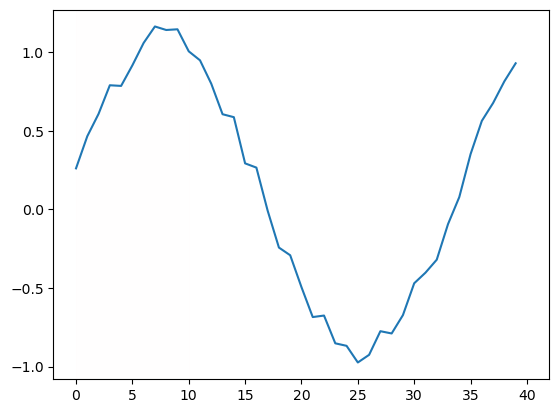

1/1 [==============================] - 0s 32ms/step
[0.9981056  0.01601277 0.01094508 0.04410776]


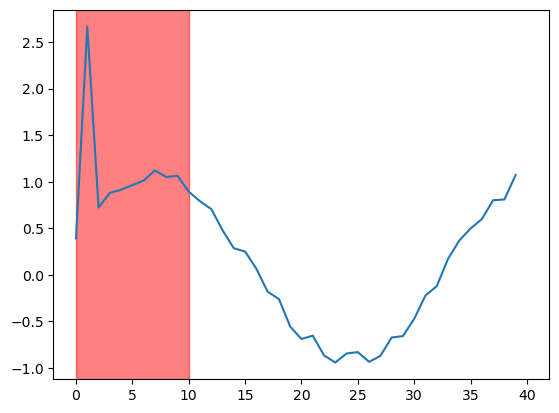

1/1 [==============================] - 0s 21ms/step
[0.05000933 0.01834024 0.01262567 0.03218306]


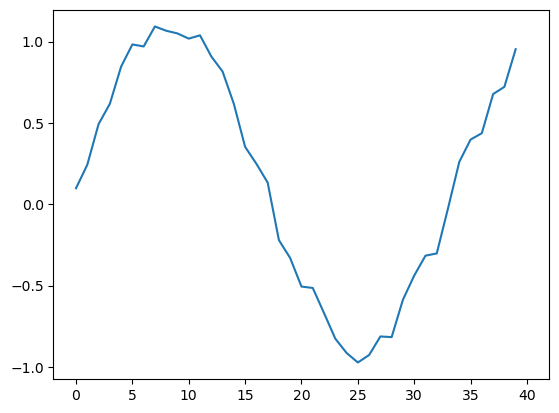

1/1 [==============================] - 0s 23ms/step
[0.04458483 0.01351195 0.01645251 0.04044413]


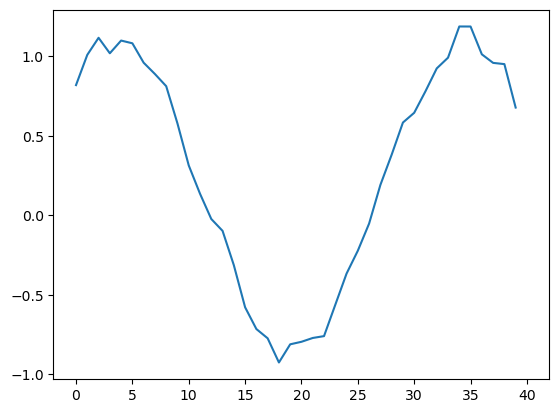

1/1 [==============================] - 0s 25ms/step
[0.06704754 0.01423264 0.01070664 0.08785559]


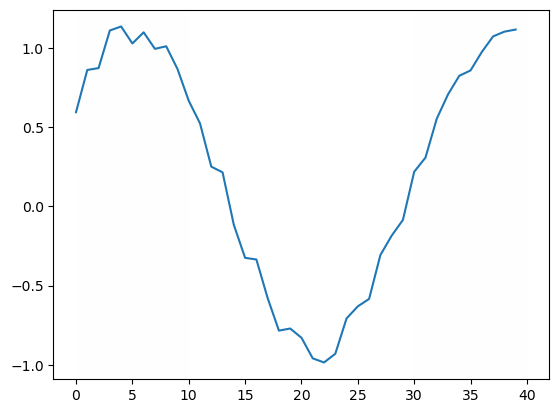

1/1 [==============================] - 0s 25ms/step
[0.02983524 0.9671477  0.01602452 0.02302368]


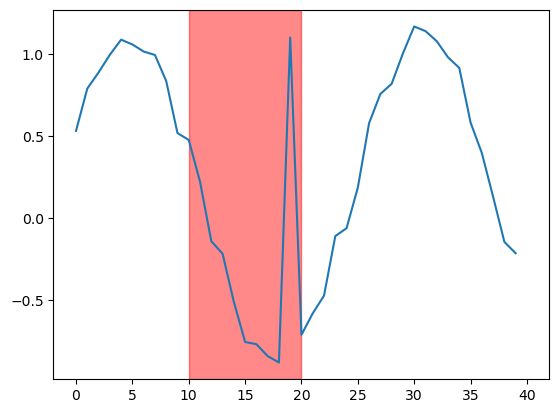

1/1 [==============================] - 0s 36ms/step
[0.02543568 0.01406908 0.01480586 0.01389237]


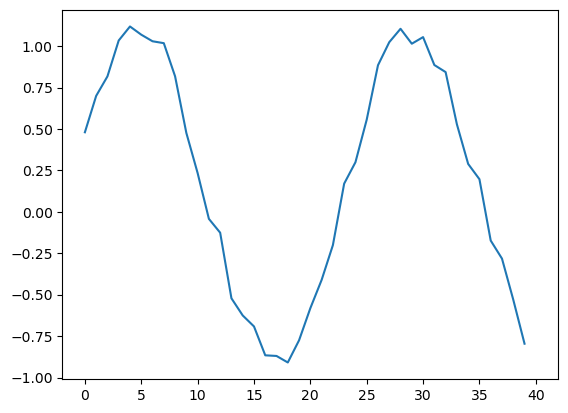

1/1 [==============================] - 0s 27ms/step
[0.03711934 0.01534615 0.02238828 0.01841811]


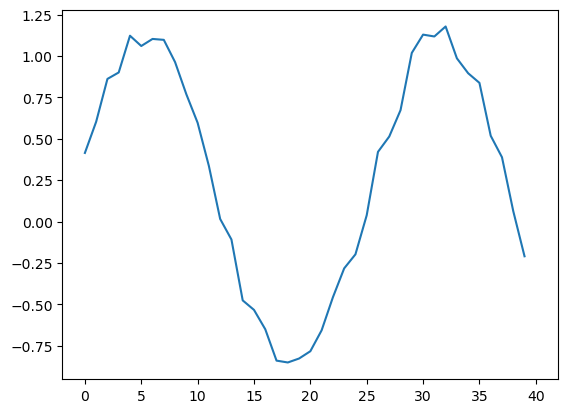

1/1 [==============================] - 0s 23ms/step
[0.02887435 0.01298005 0.99731493 0.02725512]


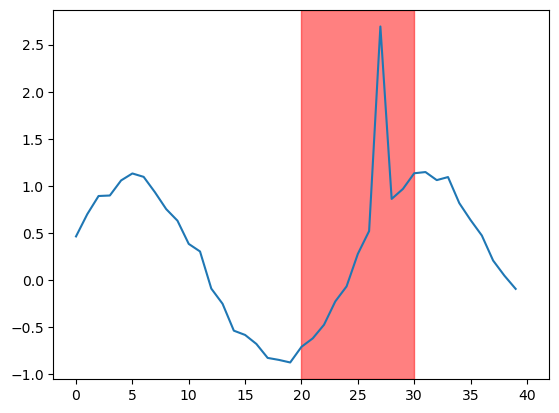

1/1 [==============================] - 0s 24ms/step
[0.0699869  0.01562404 0.01316594 0.03559752]


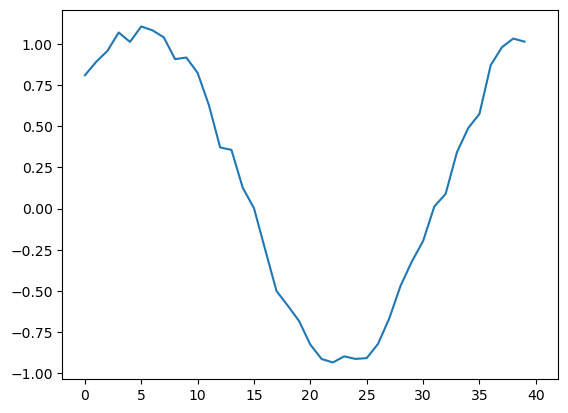

In [52]:
for i in np.random.randint(0, len(X_test), 10):
    colors = model_slice.predict(X_test[i:i+1]).flatten()
    print(colors)
    plt.plot(X_test[i])
    for j, q in enumerate(colors):
        plt.axvspan(j*INTERVAL_LENGTH, j*INTERVAL_LENGTH+INTERVAL_LENGTH, alpha=q**2*.5, color='r')
    plt.show()

### All Defects simultaneous Localization

> For now, working on truncated examples, I don't know how to reshape the sample when samples are of different length

In [53]:
X = np.stack(df_trunc.sequence,axis=0)
display(X.shape)

y = df_trunc[['d1', 'd2','d3','d4','d5']].to_numpy()
display(y.shape)

X_train = X[:11000]
y_train = y[:11000]

X_val = X[11000:15000]
y_val = y[11000:15000]

X_test = X[15000:]
y_test = y[15000:]

(50000, 40, 3)

(50000, 5)

In [54]:
inner_model = Sequential()
inner_model.add(LSTM(128, return_sequences=True, input_shape=(None,3)))
inner_model.add(LSTM(16, return_sequences=False))
inner_model.add(Dense(5, 'sigmoid'))

inner_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 128)         67584     
                                                                 
 lstm_5 (LSTM)               (None, 16)                9280      
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 76,949
Trainable params: 76,949
Non-trainable params: 0
_________________________________________________________________


In [55]:
from tensorflow.keras.layers import GlobalMaxPool2D

INTERVAL_LENGTH = 10

model = Sequential()
model.add(Reshape((4, INTERVAL_LENGTH, 3), input_shape=(40,3)))
model.add(TimeDistributed(inner_model)) # use timeDistributed to apply the same inner_model to each timestamp(slice)
model.add(GlobalMaxPool1D()) # FIXME:  # to take the maximum out of each TIme 
model.compile(loss='binary_crossentropy', metrics='acc')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 4, 10, 3)          0         
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 5)             76949     
 tributed)                                                       
                                                                 
 global_max_pooling1d_1 (Glo  (None, 5)                0         
 balMaxPooling1D)                                                
                                                                 
Total params: 76,949
Trainable params: 76,949
Non-trainable params: 0
_________________________________________________________________


In [56]:
early = EarlyStopping(patience=7)

model.fit(X_train, y_train, batch_size = 128, epochs=100, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/100
 3/86 [>.............................] - ETA: 6s - loss: 0.7075 - acc: 0.1589 

KeyboardInterrupt: 

In [59]:
if SAVE:
    model.save('./models/localizaiton-model-1')

if LOAD:
    model = load_model('./models/localizaiton-model-1')

In [60]:
model_slice = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
model_slice.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_16_input (InputLaye  [(None, 40, 3)]          0         
 r)                                                              
                                                                 
 reshape_16 (Reshape)        (None, 4, 10, 3)          0         
                                                                 
 time_distributed_16 (TimeDi  (None, 4, 5)             76949     
 stributed)                                                      
                                                                 
Total params: 76,949
Trainable params: 76,949
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 1s 946ms/step
[[0.01 0.01 0.   0.   0.  ]
 [0.03 0.01 0.04 0.   1.  ]
 [0.01 0.01 0.02 0.   0.  ]
 [0.   0.02 0.01 0.   0.  ]]
[0.03 0.02 0.04 0.   1.  ]
[False False False False  True]


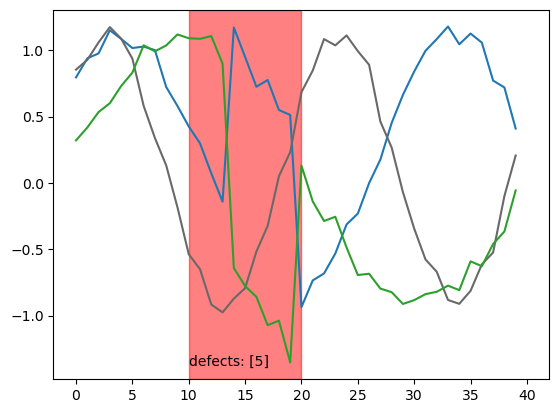

1/1 [==============================] - 0s 19ms/step
[[0.02 0.01 0.   0.   0.  ]
 [0.02 0.01 0.04 0.   1.  ]
 [0.02 0.01 1.   0.   0.01]
 [0.01 0.01 0.01 0.   0.  ]]
[0.02 0.01 1.   0.   1.  ]
[False False  True False  True]


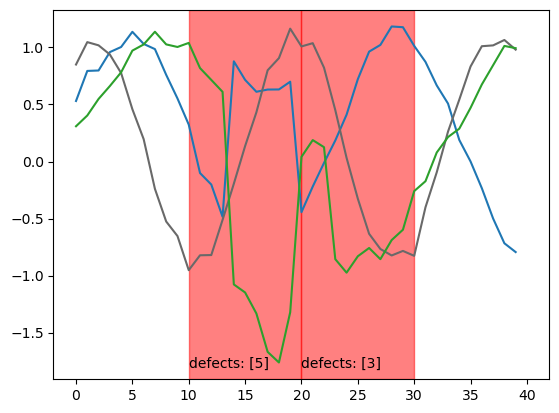

1/1 [==============================] - 0s 18ms/step
[[0.02 0.01 0.   0.   0.  ]
 [0.08 0.08 0.   0.14 0.1 ]
 [0.01 0.01 0.08 0.   0.  ]
 [0.01 0.01 0.   0.   0.  ]]
[0.08 0.08 0.08 0.14 0.1 ]
[False False False False False]


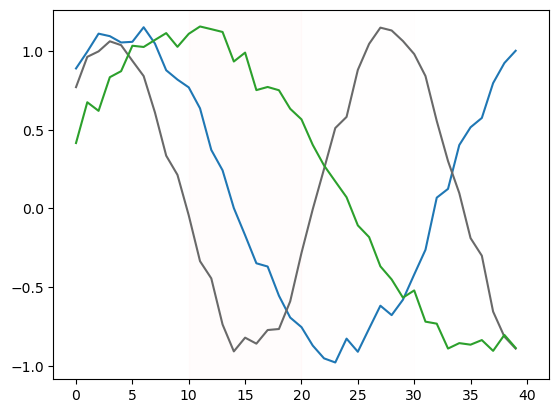

1/1 [==============================] - 0s 23ms/step
[[0.01 0.01 0.01 0.   1.  ]
 [0.02 1.   0.04 0.01 0.  ]
 [0.01 0.02 0.   0.   0.  ]
 [0.03 0.01 0.02 1.   0.  ]]
[0.03 1.   0.04 1.   1.  ]
[False  True False  True  True]


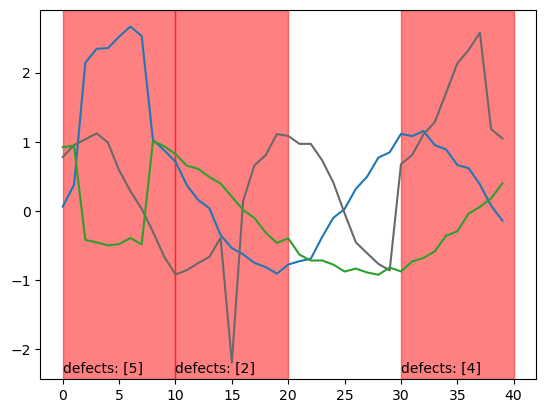

1/1 [==============================] - 0s 23ms/step
[[0.01 0.01 0.   0.   0.  ]
 [0.02 0.03 0.02 0.01 0.04]
 [0.01 0.08 0.03 0.   1.  ]
 [0.01 0.02 0.05 0.   0.  ]]
[0.02 0.08 0.05 0.01 1.  ]
[False False  True False  True]


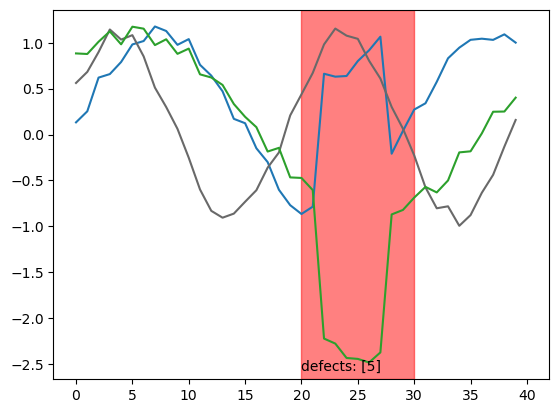

1/1 [==============================] - 0s 18ms/step
[[1.   0.   0.01 0.   0.  ]
 [0.01 0.03 0.01 0.   0.01]
 [0.02 0.02 0.   0.   0.  ]
 [0.03 0.05 0.02 1.   0.  ]]
[1.   0.05 0.02 1.   0.01]
[ True False False  True False]


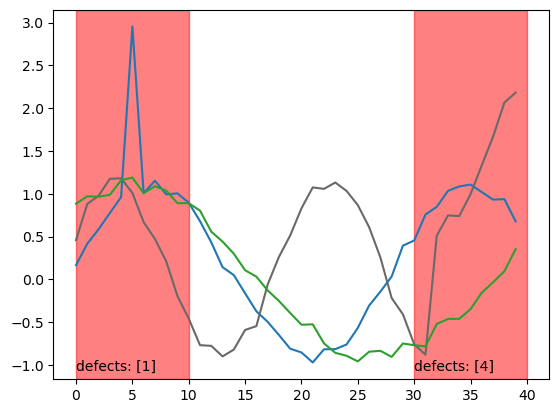

1/1 [==============================] - 0s 18ms/step
[[0.02 0.02 1.   0.01 0.  ]
 [0.05 0.07 0.   0.02 0.03]
 [1.   0.5  0.03 0.   0.  ]
 [0.01 0.02 0.01 0.   0.  ]]
[1.   0.5  1.   0.02 0.03]
[ True  True  True False False]


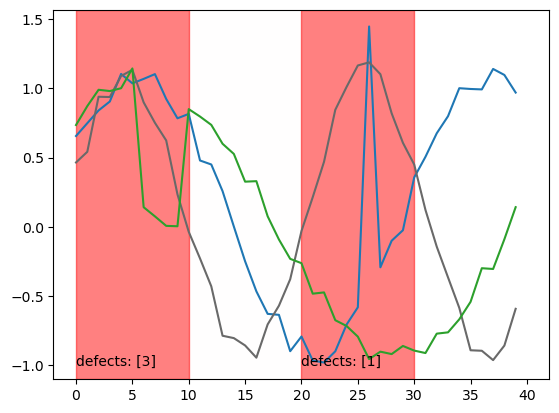

1/1 [==============================] - 0s 22ms/step
[[0.01 0.02 0.   0.   0.  ]
 [0.11 0.11 0.   0.08 0.06]
 [0.02 0.   0.08 0.   0.  ]
 [0.01 0.02 0.   0.   0.  ]]
[0.11 0.11 0.08 0.08 0.06]
[False False False False False]


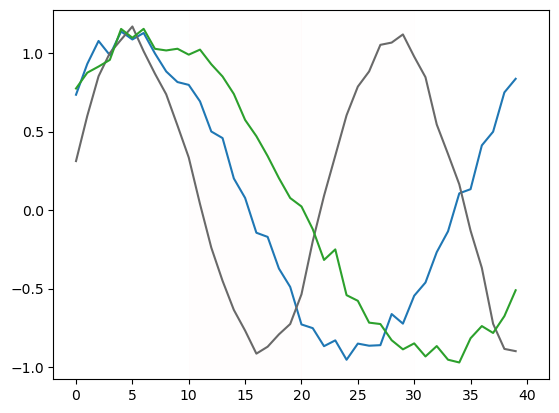

1/1 [==============================] - 0s 19ms/step
[[0.03 0.01 0.   0.   0.  ]
 [0.01 0.04 0.07 0.01 0.08]
 [0.1  0.06 0.02 0.86 0.  ]
 [0.01 0.01 0.01 1.   0.  ]]
[0.1  0.06 0.07 1.   0.08]
[False False False  True False]


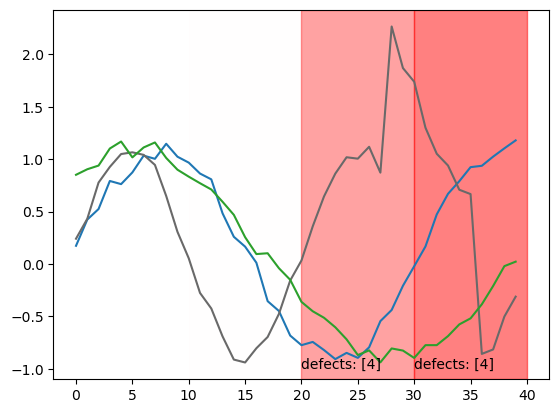

1/1 [==============================] - 0s 18ms/step
[[0.01 0.01 0.   0.   0.  ]
 [0.02 0.04 0.   0.   0.  ]
 [0.01 0.02 0.   0.   0.  ]
 [0.01 0.01 0.03 0.   0.  ]]
[0.02 0.04 0.03 0.   0.  ]
[False False False False False]


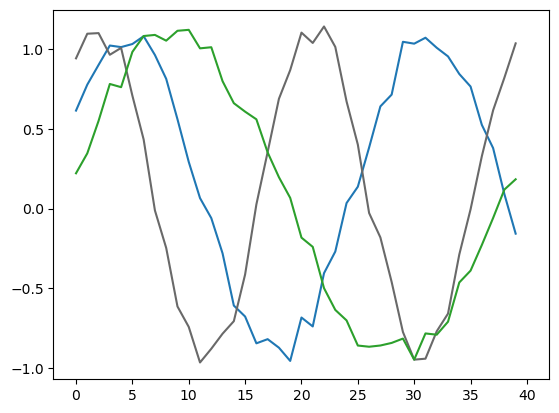

In [61]:
for i in np.random.randint(0, len(X_test), 10):
    intervals = model_slice.predict(X_test[i:i+1])[0]
    prediction = model.predict(X_test[i:i+1])[0]
    print(intervals.round(2))
    print(prediction.round(2))
    print(y_test[i])
    plt.plot(X_test[i,...,0], color='tab:blue')
    plt.plot(X_test[i,...,1], color='dimgrey')
    plt.plot(X_test[i,...,2], color='tab:green')

    for j, interval in enumerate(intervals):
        max_prob_id = np.argmax(interval)
        max_prob = interval[max_prob_id]
        defects = np.where(interval> 0.5)
        defects = defects + np.array([1])
        plt.axvspan(j*INTERVAL_LENGTH, j*INTERVAL_LENGTH+INTERVAL_LENGTH, alpha=max_prob**2*0.5, color='r')
        plt.annotate(text=f'defects: {defects[0]}' if max_prob>0.5 else '', xy=(j*INTERVAL_LENGTH, plt.ylim()[0]+ 0.10))
        
    plt.show()